<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="ffffff">
Resnet code

</font>
</h1>

pariya branch

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [24]:


# set common data augmentation parameters # dosent use
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# load training data
train_ds = ImageDataGenerator().flow_from_directory(
    r'E:\projectDataset\0minidataset\archive\sl_train',
    class_mode='categorical',
    target_size=(224,224),
    shuffle=True,
    batch_size=32
)

# load testing data
test_ds = ImageDataGenerator().flow_from_directory(
    r'E:\projectDataset\0minidataset\archive\sl_test',
    class_mode='categorical',
    target_size=(224,224),
    shuffle=False,
    batch_size=32
)

# load validation data
val_ds = ImageDataGenerator().flow_from_directory(
    r'E:\projectDataset\0minidataset\archive\sl_valid',
    class_mode='categorical',
    target_size=(224,224),
    shuffle=True,
    batch_size=32
)

# load validation data
one_cat = ImageDataGenerator().flow_from_directory(
    r'E:\projectDataset\0minidataset\oneCat',
    class_mode='categorical',
    target_size=(224,224),
    shuffle=True,
    batch_size=32
)




# load validation data
minitest = ImageDataGenerator().flow_from_directory(
    r'E:\projectDataset\0minidataset\all',
    class_mode='categorical',
    target_size=(224,224),
    batch_size=32
)

Found 2907 images belonging to 12 classes.
Found 1166 images belonging to 12 classes.
Found 1420 images belonging to 12 classes.
Found 9 images belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

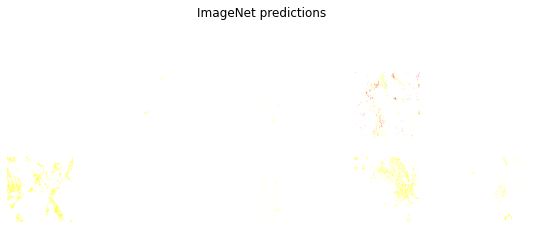

In [25]:
image_batch, label_batch = train_ds.next()

plt.figure(figsize=(10,9))
for n in range(10):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [3]:

# load ResNet50 pre-trained model
base_model = ResNet50(weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=False)

# set base model to trainable
base_model.trainable = True

base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [4]:
fine_tune_at = 140

# freeze layers before fine-tune layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [5]:

# build classification model on top of ResNet50
model = Sequential()
model.add(BatchNormalization(input_shape=(224, 224, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(9, activation='softmax'))

# print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 224, 224, 3)       12        
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               25690368  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 12)                7

In [6]:

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:

# set early stopping callback to prevent overfitting
early_stopping = EarlyStopping(patience=10)
model_checkpoint = ModelCheckpoint(
    "../Checkpoints/my_checkpoint_just_batchNormalization", save_best_only=True)

# fine-tune the model
history = model.fit(
    train_ds,
    batch_size=32,
    epochs=10,
    #epochs=27,
    validation_data=val_ds,
  #  initial_epoch=22,
    callbacks=[early_stopping,model_checkpoint]
)

Epoch 1/10
91/91 [==============================] - 934s 10s/step - loss: 3.2420 - accuracy: 0.4249 - val_loss: 6.6913 - val_accuracy: 0.4718
INFO:tensorflow:Assets written to: ../Checkpoints\my_checkpoint_just_batchNormalization\assets
Epoch 2/10
91/91 [==============================] - 892s 10s/step - loss: 0.6114 - accuracy: 0.8058 - val_loss: 0.7017 - val_accuracy: 0.7958
INFO:tensorflow:Assets written to: ../Checkpoints\my_checkpoint_just_batchNormalization\assets
Epoch 3/10
91/91 [==============================] - 3403s 38s/step - loss: 0.3024 - accuracy: 0.9057 - val_loss: 1.1405 - val_accuracy: 0.7993
Epoch 4/10
91/91 [==============================] - 880s 10s/step - loss: 0.2896 - accuracy: 0.9283 - val_loss: 43.3852 - val_accuracy: 0.3620
Epoch 5/10
91/91 [==============================] - 879s 10s/step - loss: 0.2670 - accuracy: 0.9274 - val_loss: 1.8711 - val_accuracy: 0.7246
Epoch 6/10
91/91 [==============================] - 2313s 26s/step - loss: 0.1321 - accuracy: 0.96

In [8]:
test_loss, test_accuracy = model.evaluate(test_ds)#, steps=len(test_ds)/2
print('Accuracy on test dataset:', test_accuracy)

37/37 [==============================] - 101s 3s/step - loss: 2.1757 - accuracy: 0.6973
Accuracy on test dataset: 0.697255551815033


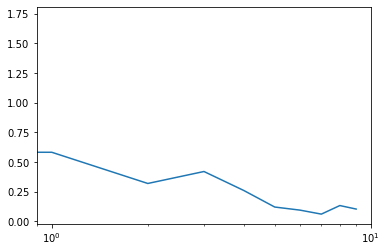

In [9]:
plt.semilogx( history.history["loss"])

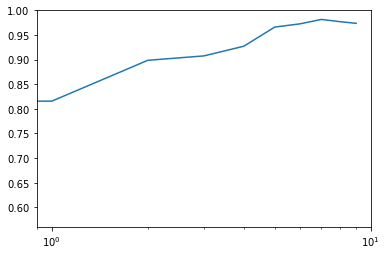

In [10]:
plt.semilogx( history.history["accuracy"])

In [11]:
model.save('../models/fruit_disease_classifier_resnet_just_batch_nurmaliztion.h5')

In [12]:

######یادت باشه دیتاها رو تغییر دادی طول میکشه چون داده ها ما خیل هستن 
predicted_batch = model.predict(train_ds)
import numpy as np
predicted_ids = np.argmax(predicted_batch, axis=-1)
class_names = list(train_ds.class_indices.keys())
predicted_class_names = [class_names[id] for id in predicted_ids]

image_batch, label_batch = train_ds.next()


In [13]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(train_ds, verbose=2)

print('Test accuracy:', test_acc)


91/91 - 246s - loss: 0.0759 - accuracy: 0.9735
Test accuracy: 0.9735122323036194


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['Beans_Angular_LeafSpot', 'Beans_Rust', 'Strawberry_Angular_LeafSpot', 'Strawberry_Anthracnose_Fruit_Rot', 'Strawberry_Blossom_Blight', 'Strawberry_Gray_Mold', 'Strawberry_Leaf_Spot', 'Strawberry_Powdery_Mildew_Fruit', 'Strawberry_Powdery_Mildew_Leaf', 'Tomato_Blight', 'Tomato_Leaf_Mold', 'Tomato_Spider_Mites']


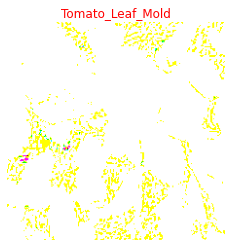

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


real label : [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
predicted: ['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '1.000', '0.000']


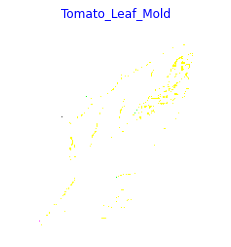

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


real label : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
predicted: ['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '1.000', '0.000']


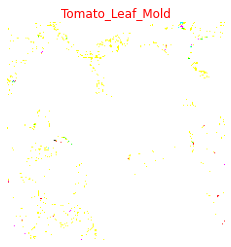

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


real label : [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
predicted: ['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '1.000', '0.000']


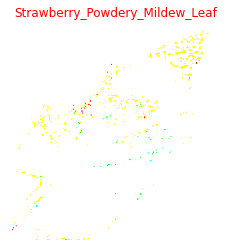

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


real label : [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
predicted: ['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '1.000', '0.000', '0.000', '0.000']


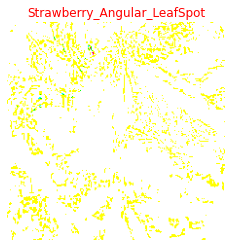

real label : [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
predicted: ['0.000', '0.000', '0.997', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.001', '0.001', '0.000']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


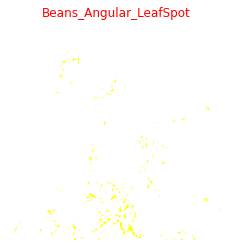

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


real label : [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
predicted: ['0.999', '0.001', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000']


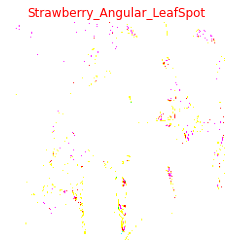

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


real label : [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
predicted: ['0.000', '0.000', '0.998', '0.000', '0.000', '0.000', '0.000', '0.002', '0.000', '0.000', '0.000', '0.000']


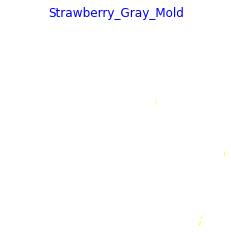

real label : [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
predicted: ['0.000', '0.000', '0.000', '0.000', '0.000', '1.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


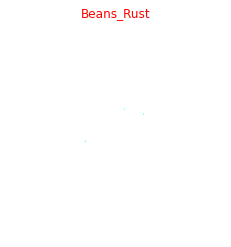

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


real label : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
predicted: ['0.000', '1.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000']


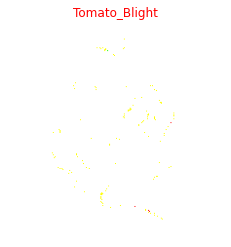

real label : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
predicted: ['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.999', '0.000', '0.001']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


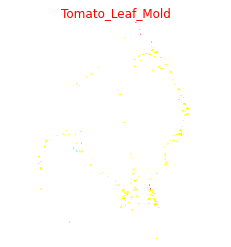

real label : [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
predicted: ['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.002', '0.998', '0.000']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


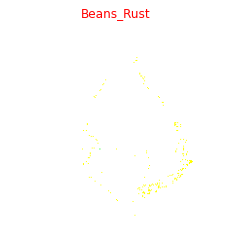

real label : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
predicted: ['0.000', '1.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


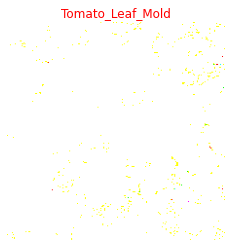

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


real label : [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
predicted: ['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.035', '0.965', '0.000']


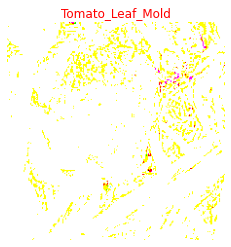

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


real label : [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
predicted: ['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '1.000', '0.000']


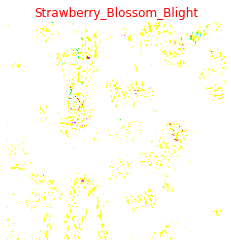

real label : [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
predicted: ['0.000', '0.000', '0.000', '0.000', '1.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


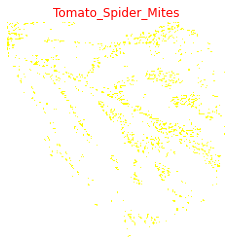

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


real label : [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
predicted: ['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '1.000']


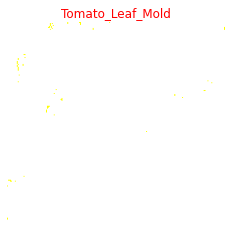

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


real label : [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
predicted: ['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.029', '0.971', '0.000']


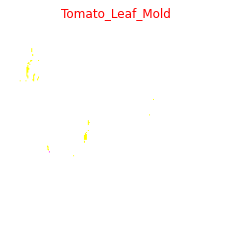

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


real label : [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
predicted: ['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.141', '0.858', '0.000']


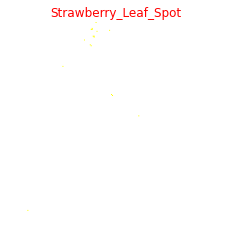

real label :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
predicted: ['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.993', '0.000', '0.006', '0.000', '0.000', '0.000']


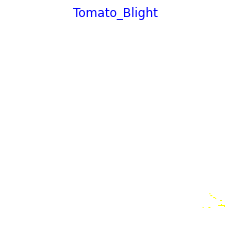

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


real label : [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
predicted: ['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '1.000', '0.000', '0.000']


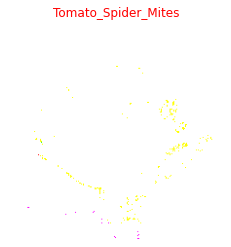

real label : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
predicted: ['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.007', '0.000', '0.993']


In [16]:


import matplotlib.pyplot as plt
print(class_names)
for n in range(21):
    plt.axis('off')
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == tf.math.argmax(label_batch[n]) else "red"
  #  plt.title(predicted_class_names[n], color=color)
    plt.title(predicted_class_names[n], color=color)
    plt.show()
    print('real label :',label_batch[n])
    my_formatted_list = [ '%.3f' % elem for elem in predicted_batch[n] ]
    print('predicted:', my_formatted_list)
    

#print(predicted_batch[n])




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

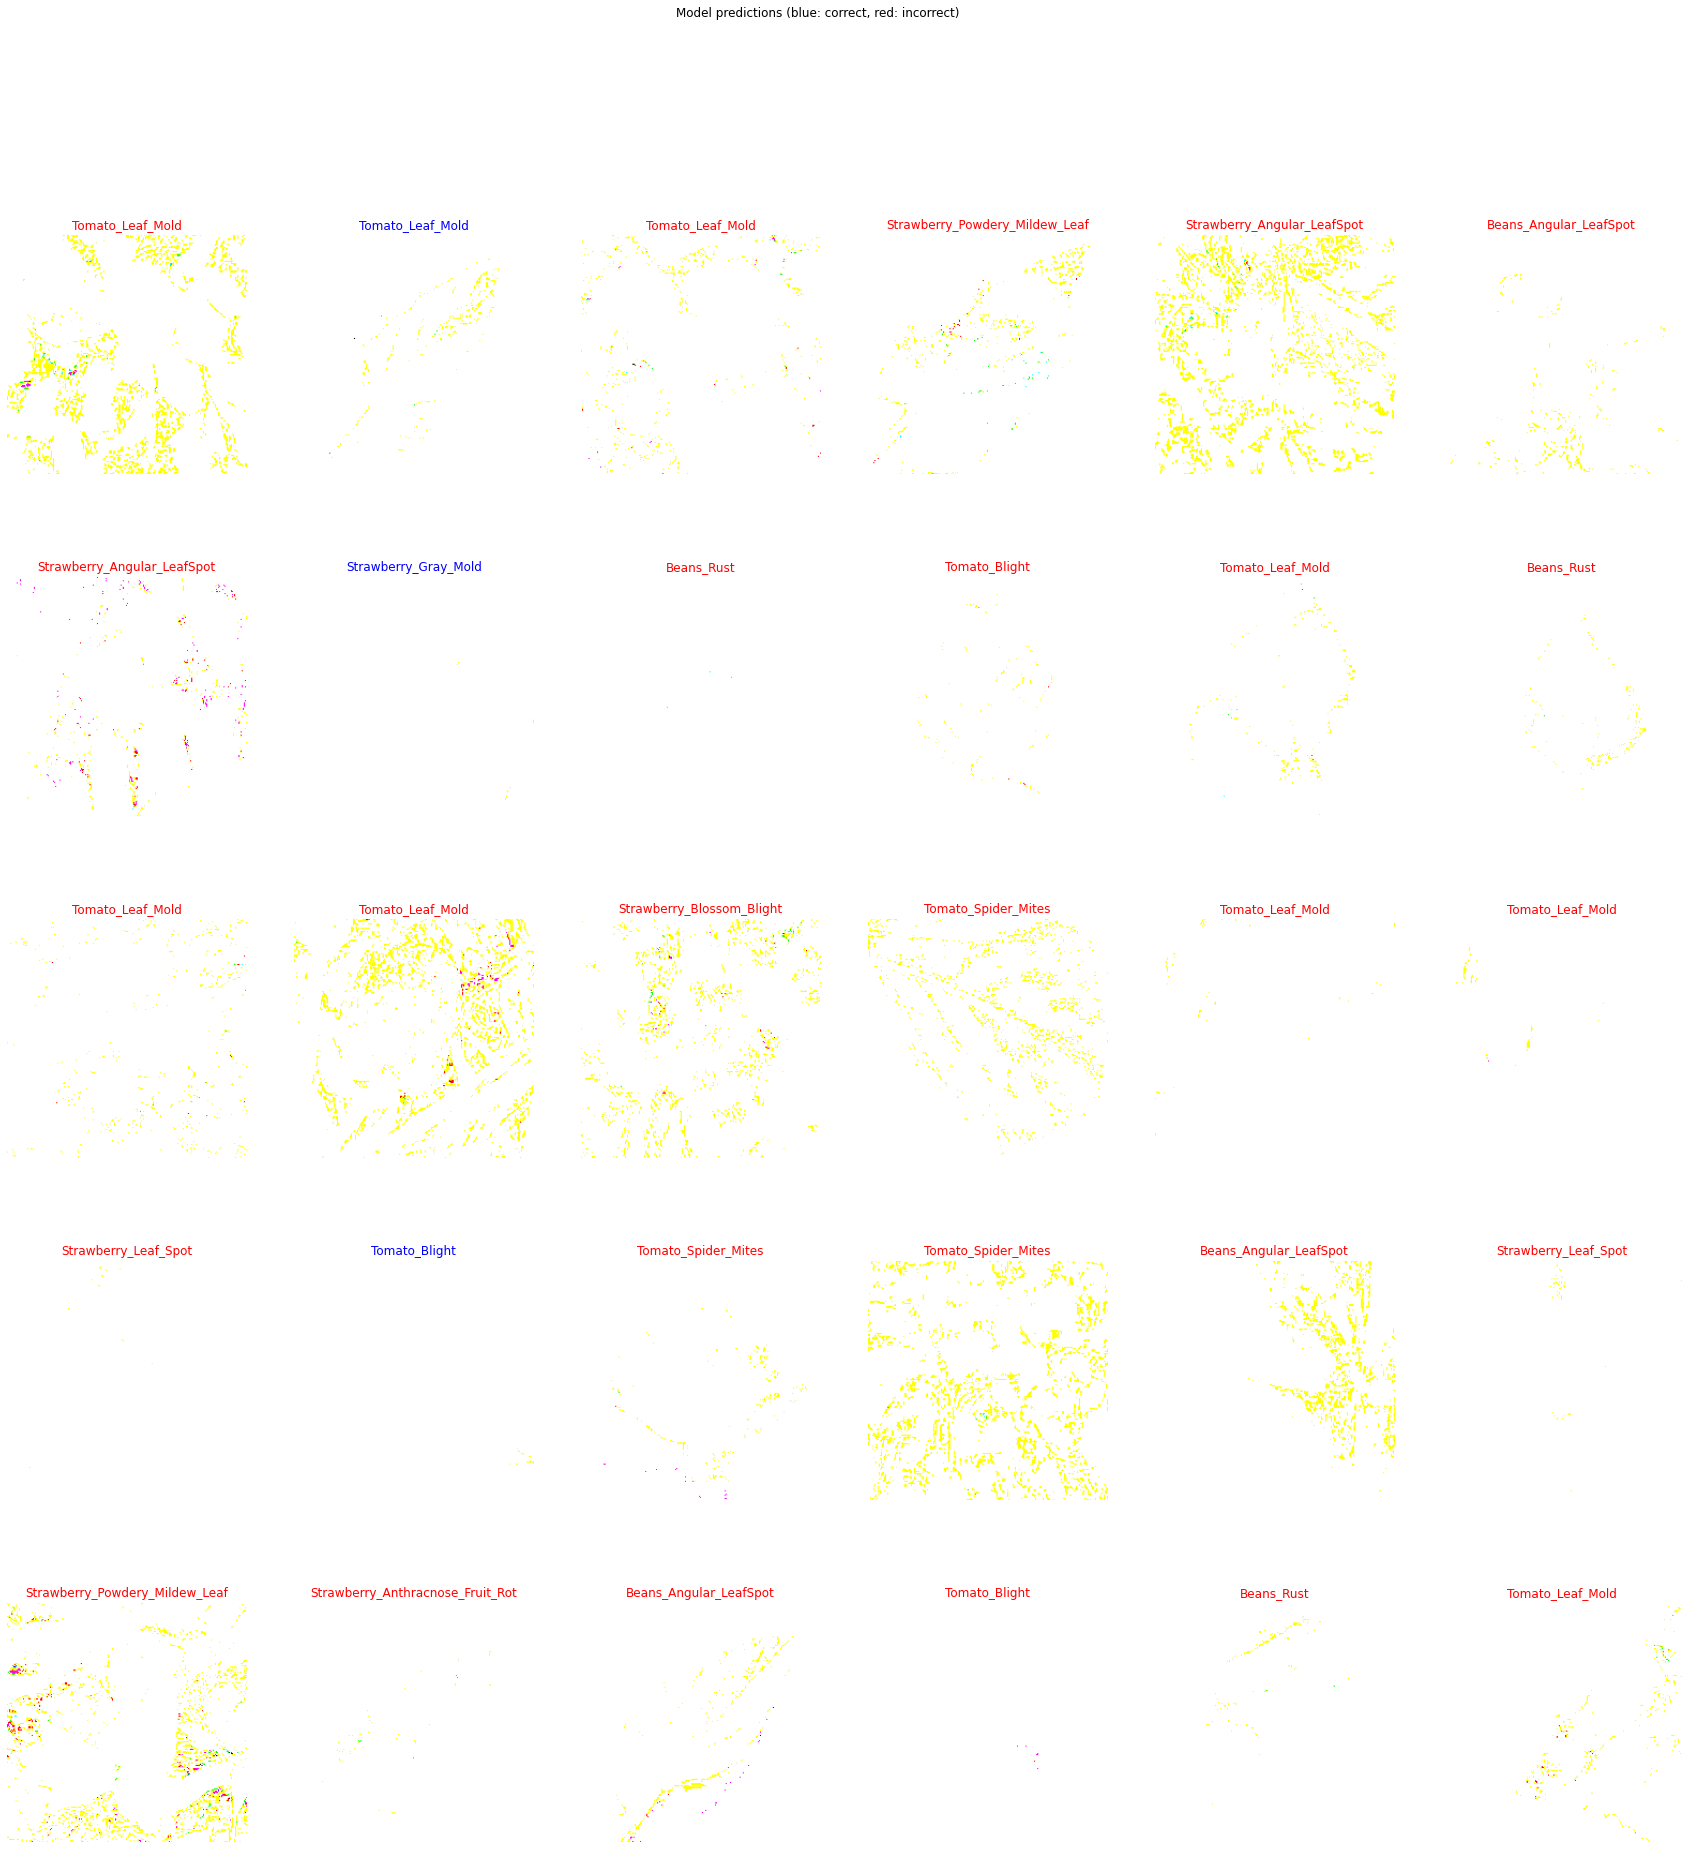

In [15]:


predicted_batch = model.predict(train_ds)
predicted_ids = np.argmax(predicted_batch, axis=-1)
class_names = list(train_ds.class_indices.keys())
predicted_class_names = [class_names[id] for id in predicted_ids]

import matplotlib.pyplot as plt
image_batch, label_batch = train_ds.next()

plt.figure(figsize=(30,30))
for n in range(30):
    plt.subplot(5,6,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == tf.math.argmax(label_batch[n]) else "red"
  #  plt.title(predicted_class_names[n], color=color)
    plt.title(predicted_class_names[n], color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")